In [21]:
from tqdm import tqdm
import pandas as pd
import re
import random

In [22]:
data = pd.read_csv('Myntra Fasion Clothing.csv',encoding='utf-8')
data.head()

/var/folders/hs/bg0sjys12tqgftpwb7z0s8j00000gn/T/ipykernel_84935/1723055547.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Myntra Fasion Clothing.csv',encoding='utf-8')


,URL,Product_id,BrandName,Category,Individual_category,category_by_Gender,Description,DiscountPrice (in Rs),OriginalPrice (in Rs),DiscountOffer,SizeOption,Ratings,Reviews
0,https://www.myntra.com/jeans/roadster/roadster...,2296012,Roadster,Bottom Wear,jeans,Men,roadster men navy blue slim fit mid rise clean...,824.0,1499.0,45% OFF,"28, 30, 32, 34, 36",3.9,999.0
1,https://www.myntra.com/track-pants/locomotive/...,13780156,LOCOMOTIVE,Bottom Wear,track-pants,Men,locomotive men black white solid slim fit tra...,517.0,1149.0,55% OFF,"S, M, L, XL",4.0,999.0
2,https://www.myntra.com/shirts/roadster/roadste...,11895958,Roadster,Topwear,shirts,Men,roadster men navy white black geometric print...,629.0,1399.0,55% OFF,"38, 40, 42, 44, 46, 48",4.3,999.0
3,https://www.myntra.com/shapewear/zivame/zivame...,4335679,Zivame,Lingerie & Sleep Wear,shapewear,Women,zivame women black saree shapewear zi3023core0...,893.0,1295.0,31% OFF,"S, M, L, XL, XXL",4.2,999.0
4,https://www.myntra.com/tshirts/roadster/roadst...,11690882,Roadster,Western,tshirts,Women,roadster women white solid v neck pure cotton ...,NaN,599.0,35% OFF,"XS, S, M, L, XL",4.2,999.0


In [23]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra white spaces
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = text.lower().strip()  # Remove special characters
    return text

# Apply the function to the specific column
data['BrandName'] = data['BrandName'].apply(clean_text)
data['Description'] = data['Description'].apply(clean_text)

In [89]:
import random

df = data

def shuffle_description(description):
    words = description.split()
    random.shuffle(words)
    return ' '.join(words)

def reverse_description(description):
    words = description.split()
    words.reverse()
    return ' '.join(words)

def shorten_description(description, max_length=4):
    words = description.split()
    if len(words) > max_length:
        words = random.sample(words, max_length)
    return ' '.join(words)

desc = []
brandname = []

for b, d in zip(df['BrandName'], df['Description']):
    if len(b.split()) == 1:
        shuffled_desc = shuffle_description(d)
        shortened_desc = shorten_description(shuffled_desc)
        desc.append(shortened_desc)
    else:
        desc.append(d)
    brandname.append(b)

df = pd.DataFrame({
    'BrandName':brandname,
    'Description':desc,
    'Category':df['Category']
})

In [90]:

df = df.sample(1000)

# df = df.groupby('Category', group_keys=False).apply(lambda x: x.sample(min(len(x), 1000 // df['Category'].nunique())))

In [91]:
import pandas as pd
import joblib
import spacy
from elasticsearch import Elasticsearch

try:
    classifier = joblib.load('text_classifier_model.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    nlp = spacy.load("ner_fashion_model")
except Exception as e:
    print(f"Error loading models: {e}")

# Connect to Elasticsearch
try:
    es_host = "https://localhost:9200"
    es_username = "elastic"
    es_password = "WLr9YJy_OSe=POPdH3d1"
    es = Elasticsearch(
        es_host,
        http_auth=(es_username, es_password),
        verify_certs=False
    )
except Exception as e:
    print(f"Error connecting to Elasticsearch: {e}")

index_name = "products"
RESULTS_PER_PAGE = 10

# Initialize lists to store search result counts
simple_search_counts = []
advanced_search_counts = []

for index, row in df.iterrows():
    print(index)
    search_query = row['Description']

    # Perform simple search
    simple_search_body = {
        "query": {
            "match": {
                "description": search_query
            }
        },
        "size": RESULTS_PER_PAGE
    }
    simple_response = es.search(index=index_name, body=simple_search_body)
    simple_total_results = simple_response['hits']['total']['value']
    simple_search_counts.append(simple_total_results)

    # Predict category using classifier
    X_new = vectorizer.transform([search_query])
    predicted_category = classifier.predict(X_new)[0]

    # Perform Named Entity Recognition (NER) to identify brand
    doc = nlp(search_query)
    identified_brand = None
    for ent in doc.ents:
        if ent.label_ == 'BRAND':
            identified_brand = ent.text
            break

    # Perform advanced search with additional filters
    must_clauses = [{"match": {"description": search_query}}]
    if identified_brand:
        must_clauses.append({"match": {"brand": identified_brand}})
    if predicted_category:
        must_clauses.append({"match": {"category": predicted_category}})

    advanced_search_body = {
        "query": {
            "bool": {
                "must": must_clauses
            }
        },
        "size": RESULTS_PER_PAGE
    }
    advanced_response = es.search(index=index_name, body=advanced_search_body)
    advanced_total_results = advanced_response['hits']['total']['value']
    advanced_search_counts.append(advanced_total_results)

# Add the search result counts to the dataframe
df['simple_search_count'] = simple_search_counts
df['advanced_search_count'] = advanced_search_counts

# Save the updated dataframe to a new CSV file
df.to_csv('test_data_with_search_counts.csv', index=False)

print("Search results have been stored in 'test_data_with_search_counts.csv'")


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle e

158989
173998
287555
229568
367378


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

198023
480979
133647
409259
176373
86825
432616
25008
251508
6102
453456
111791
14827
339395
320613
413620


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

62220
464265
144540
40783
128173
96100
473685
23526
91222
190372
131018
175690
176828
216212
90795
524196
505720


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

467559
26909
234083
123129
377920
382566
298343
151065
372565
236452
386226
391372
267953
405637
284945
447329


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

38018
195221
86306
68063
398698
241688
456243
420043
407058
178856
400269
161423
124935
371174
394228
181716
291345
273781


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

50673
175212
202216
428505
282129
339296
13967
342573
95588
516833
144576
70703
187317
277629
75486
460114
219909
493696
90404
341747


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

503716
40374
286482
147614
280686
501197
394688
433527
334558
147521
272127
433197
237625
182882
366813
396931
84528
94570
322016
50209


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

257056
165893
295949
381913
57328
99691
459383
146009
182996
305274
217056
204168
8669
397714
84712
146877
368252
479862
338206
62877


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

388498
504242
401149
290177
394749
353057
153449
97788
82423
397712
220197
467804


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

352489
388049
98260
470163
166317
6834
382390
426685
195027
24199
453096
312132
206207
368451
181954
15612
126131


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

208935
166003
379727
135130
338169
144585
437159
244303
461560
223589
314675
15043
406802
244011


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

295593
470292
325824
62968
173434
522771
400949
289398
211576
98318
330202
3822
250200
130692
523691


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

307812
202437
2327
133985
364893
252466
18313
502210
269700
307220
373416
92323
184940
126936
228187
480314
180227
336792


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

289782
102324
159868
122071
503442
198690
228419
413440
167854
507603
5271
526171
234646
233198
473313
166308
99131


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

458503
145089
87948
488245
389568
66076
471839
35395
100486
323521
213914
99930
171393
304848
66265
302720
311601
498366
297042


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

123108
350008
475644
525865
270283
198064
518296
474375
344621
313970
486235
383354
495822
164816
253778
351021
402578
280799
17455
102768
412939


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

336031
470440
356009
320518
406416
495338
63043
279720
162034
81644
258108
87782
6007
62736
143613
277139
47150


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

148156
264240
285986
124903
474193
405164
238028
225672
89727
270050
204714
109310
173899
459930
146609
342939
378121
163323
258550
398584
48668


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

92700
144765
144194
248465
46549
282013
292597
398803
479338
179024
98924
488859
31035
211789
513473
249335
154062
90183
25431


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

155056
334653
61904
37430
160152
15614
111200
114003
117428
97626
356929
385038
238804
376990


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

435687
277202
86174
72829
488582
420046
132351
57387
393292
310470
103373
255176
336892
122435
475163
191760


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

385568
514062
467326
77062
366142
285527
73587
443554
49818
91702
194227
386610
521491
190878
189049
498550
141294
42615


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

78758
110747
321858
99199
201138
53528
274740
203631
499010
60710
81834
147192
253506
291664
402132
181612
93453
522961
170049


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

282368
479937
248945
508327
426646
135477
368562
90072
108118
481635
518289
68053
449551
92705
526088
135586
189496
457504


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

446979
157188
514827
38853
35089
377506
4742
165266
363585
277620
372228
165808
276598
175044


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

162573
495843
516150
125907
397751
464689
144771
481496
291540
116253
418458
425117
185042
77723
485112
473080
357825
344712
289460
132615
356243
76516


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

341553
198820
173328
351481
153010
188285
38644
222718
502257
331586
83528
377074
385159
73840
51598
48317
57735
342895


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

352785
445703
1851
289473
440808
29949
355935
338258
485369
87650
300127
50908
247647
474215
223372
211937
221190


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

407588
1320
458596
129209
511943
60886
313897
13364
207926
402575
102208
363318
46966
273782
456479
135192
118194
178839
221754
267936


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

269140
135444
248817
399756
481332
43449
56974
381636
1097
278087
377921
253318
472741
74120
340825
18035
309739


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

360381
56381
384234
67823
310835
25413
324674
437605
308308
196998
36313
212433
288743
444757
174616
244053


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

361338
283293
90427
495297
380524
25292
128809
112141
502175
251546
423319
343894
343823
280151
212270
515404
370191
134120
74617


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

117374
385680
362844
50221
231603
184609
521580
55124
98019
43630
213139
234001
214704
347303
426782
167618
264818
13225
462641
514282


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

319931
220689
98279
428688
274904
191162
120428
454198
67938
185452
489838
220774
518673
10577
32186
410724
344244
115572


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

305568
484573
493736
193540
93708
397496
303345
85679
358587
154016
475282
331183
365825
362274
323894
337045
188058


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

236574
19264
81460
204335
294840
322801
279665
290081
447228
408949
288882
261562
140375
200249
450951


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

461879
56453
23878
404419
70086
445422
19474
365690
283245
432950
241311
318357
186520
397727
377326
102604
212134
187367
44549


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

81902
134391
71003
385618
279092
235540
145346
5344
100090
92126
424021
43195
84759
458558
176869


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

478898
10342
310
334944
147076
194738
3896
79666
503145
25825
250474
334051


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

70232
8570
408894
357092
332933
162238
202696
61763
367879
10211
208496
47017
474828
357195
433274
254424
128388
395600
454202
158


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

180123
138128
17767
178065
347680
277911
406852
32825
428720
207
489548
349054
477454
228989
284327
36691
465332
34513
226470
65897


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

139729
224851
390447
55644
167350
277722
412139
449315
401264
142252
230896
115992
143167
149132
373606
507096
240218


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

411660
221360
149623
374549
165777
379760
309133
449326
354041
461096
371909
189825
2181
146717
91156
362474
342412
511553


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

263383
269085
255840
420334
499231
370670
60229
257711
421414
52375
267304
183913
105413
90056
437154
337359
271783
22268


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

503883
39925
322521
316225
242774
401604
408134
188360
118853
466163
486258
215640
21533
58313
110622
371734
419255


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

526253
426355
534
39399
181760
374855
249959
490146
404375
148154
307820
432694
50695
47926
521667
194868
48341


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

506514
452893
83544
252518
215282
42119
124911
402317
100668
426158
261628
119631
138476
367227


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

134949
276301
500213
218735
198269
254882
412229
228772
205702
87284
465679
23406
238074
74386
382699
401577
304255
468858
289376
63038
103689


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

489546
97708
362286
449818
21031
391005
186087
317083
413489
78310
88558
372660
327670
204044
489993
405604
343973
490246
125677
49859


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

17730
46095
141814
123135
122508
151313
34847
209893
479285
295363
262769
55454
175984
392419
266870
16653
287269
102888
104470
184505


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

116773
249076
199973
375309
284936
354013
416485
500865
495700
281786
353369
183874
137124
30827
279637
446625
369350
262924
144112
8091


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

370644
31705
420361
489059
319419
398100
361430
82137
400284
185525
471513
499914
42332
51227
266582
360
497571
189459
275302
413290
117799


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

171512
46438
220271
98648
173736
30773
388729
155374
196685
149611
432488
493912
24449
355504
389941
453125


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

235266
363867
284015
377431
226140
481771
240414
202152
190355
488815
484976
221430
152471
264360
11444
479174
110260
331758
429414
465451


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

228685
175771
24162
308820
79175
218982
110068
11412
512889
248670
129369
428060
377525
317999
211713
184337


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

420694
121632
353296
420657
29711
416837
406499
91167
238082
354134
100509
41176
40614
47353
288108
123918
273791


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

56282
339594
431968
149414
448667
206233
134627
80745
196339
228584
269442
250352
69553
328180
300363
391869
397638
81096


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

183575
12683
153047
429453
Search results have been stored in 'test_data_with_search_counts.csv'


/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/yashrajsingh/MSc Project/NER App/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  w

In [92]:
df.head()

,BrandName,Description,Category,simple_search_count,advanced_search_count
158989,fruit of the loom,fruit of the loom women pack of 3 solid bikini...,Lingerie & Sleep Wear,10000,5846
173998,monte carlo,monte carlo women grey lightweight quilted woo...,Western,10000,290
287555,yoonoy,organic black sweatshirt yoonoy,Topwear,10000,93
229568,anug by sojanya,anug by sojanya men mustard yellow yoke design...,Indian Wear,10000,10000
367378,ethnic basket,ethnic basket women set of 4 pink blue floral ...,Indian Wear,10000,4974


In [93]:
df['simple_search_count'].value_counts()

simple_search_count
10000    991
8351       1
8925       1
3993       1
1257       1
8101       1
6252       1
6229       1
7217       1
8378       1
Name: count, dtype: int64

In [94]:
df['advanced_search_count'].value_counts()

advanced_search_count
10000    355
0         12
1458       7
4447       7
2613       7
        ... 
290        1
55         1
725        1
376        1
706        1
Name: count, Length: 389, dtype: int64

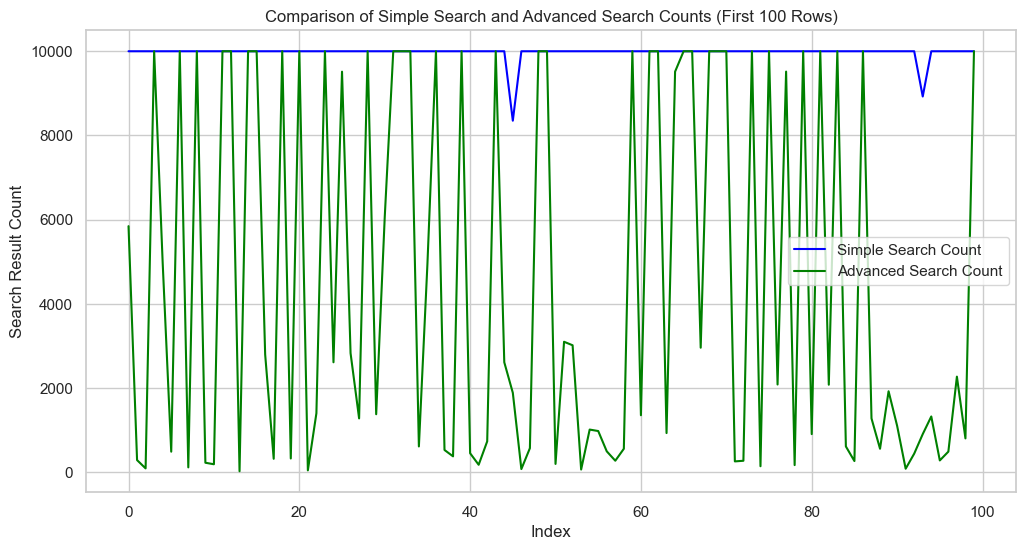

In [98]:

df = pd.read_csv('test_data_with_search_counts.csv')


df_subset = df.iloc[:100]


sns.set(style="whitegrid")


plt.figure(figsize=(12, 6))


sns.lineplot(x=range(len(df_subset)), y='simple_search_count', data=df_subset, label='Simple Search Count', color='blue')

sns.lineplot(x=range(len(df_subset)), y='advanced_search_count', data=df_subset, label='Advanced Search Count', color='green')

plt.title('Comparison of Simple Search and Advanced Search Counts (First 100 Rows)')
plt.xlabel('Index')
plt.ylabel('Search Result Count')

plt.legend()

# Show the plot
plt.show()

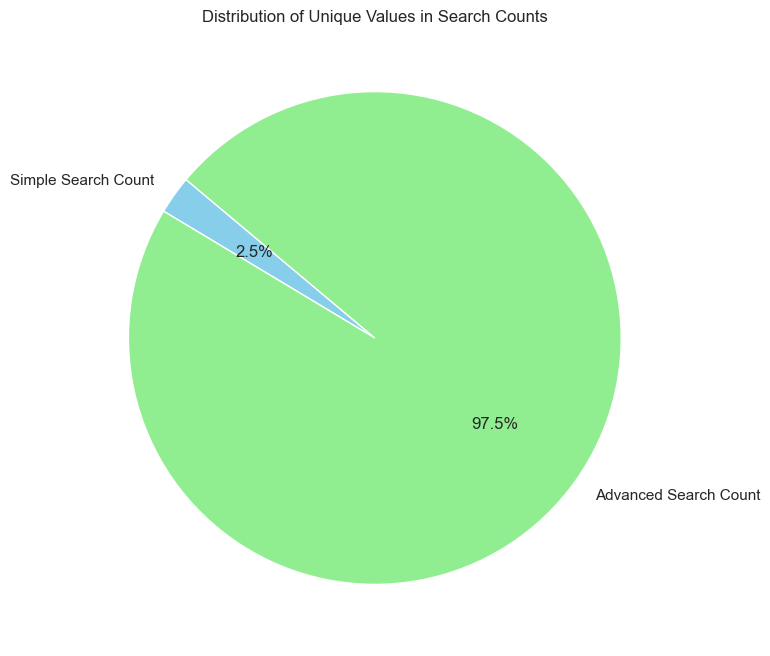

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('test_data_with_search_counts.csv')


unique_simple_search_count = df['simple_search_count'].nunique()
unique_advanced_search_count = df['advanced_search_count'].nunique()


labels = ['Simple Search Count', 'Advanced Search Count']
sizes = [unique_simple_search_count, unique_advanced_search_count]
colors = ['skyblue', 'lightgreen']


plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)


plt.title('Distribution of Unique Values in Search Counts')


plt.show()


In [103]:
import pandas as pd
import matplotlib.pyplot as plt

df['reduction_percentage'] = ((df['simple_search_count'] - df['advanced_search_count']) / df['simple_search_count']) * 100

comparison = df[['BrandName', 'simple_search_count', 'advanced_search_count', 'reduction_percentage']]
print(comparison)

             BrandName  simple_search_count  advanced_search_count  \
0    fruit of the loom                10000                   5846   
1          monte carlo                10000                    290   
2               yoonoy                10000                     93   
3      anug by sojanya                10000                  10000   
4        ethnic basket                10000                   4974   
..                 ...                  ...                    ...   
995            herenow                10000                   3294   
996            jansons                10000                  10000   
997          berrylush                10000                    643   
998            wishful                10000                  10000   
999            urbanic                10000                    706   

     reduction_percentage  
0                   41.54  
1                   97.10  
2                   99.07  
3                    0.00  
4                  

In [104]:
mean_reduction_percentage = df['reduction_percentage'].mean()
mean_reduction_percentage

54.16849034496216